In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
from MakePlots import *
import os
import random
from scipy import stats
from itertools import groupby,combinations
from scipy.optimize import curve_fit
from scipy.stats import t
import statsmodels.api as sm

In [ ]:
analysis_dir = Path('/path/to/AnalysisAndFigures-Final')
total_aggregated_df = pd.read_csv(analysis_dir/'3_Collapsed_Cluster_Correlation_L85.tsv',delimiter='\t')
figure_dir = analysis_dir/'SpecializedPlots'
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

operator_for_average = '75pct'

patient_key = pd.read_excel('/path/to/PatientKey.xlsx')

In [22]:
control_samples = patient_key[patient_key.FigureName.apply(lambda x: 'Control' in x)]['Sample'].tolist()
proband_samples = patient_key[patient_key.FigureName.apply(lambda x: 'Proband' in x)]['Sample'].tolist()

relevant_cols = ['allele_id']+[x for x in total_aggregated_df.columns if x.split('_')[0] in control_samples+proband_samples]
prob_control_df = total_aggregated_df[relevant_cols].copy()

In [26]:
for patient_id in control_samples+proband_samples:
    prob_control_df[f'{patient_id}_total_tel_len'] = prob_control_df.apply(lambda x: get_tel_len_list(x[f'{patient_id}_read_TLs'],True,x[f'{patient_id}_tvr_len']),axis=1)
    prob_control_df[f'{patient_id}_{operator_for_average}_tel_len'] = prob_control_df[f'{patient_id}_total_tel_len'].apply(lambda x: find_average(x,operator_for_average))
    prob_control_df[f'{patient_id}_{operator_for_average}_tel_std_dev'] = prob_control_df[f'{patient_id}_total_tel_len'].apply(lambda x: np.std(x))

In [38]:
std_dev_df = []
for patient_id in control_samples+proband_samples:
    patient_cols = ['allele_id']+[x for x in prob_control_df.columns if patient_id in x]
    tdf = prob_control_df[patient_cols].copy()
    tdf.dropna(subset=f'{patient_id}_tvr_consensus',inplace=True)

    patient_df = pd.DataFrame()
    patient_df['allele_id'] = tdf['allele_id'].tolist()
    patient_df[f'{operator_for_average}_tel_len'] = tdf[f'{patient_id}_{operator_for_average}_tel_len'].tolist()
    patient_df[f'tel_std_dev'] = tdf[f'{patient_id}_{operator_for_average}_tel_std_dev'].tolist()
    patient_df['sample'] = patient_id
    figurename = patient_key[patient_key.Sample==patient_id]['FigureName'].item()
    patient_df['figure_name'] = figurename
    patient_df['allele_class'] = figurename.split(' ')[0]

    std_dev_df.append(patient_df)
std_dev_df = pd.concat(std_dev_df)

<Axes: xlabel='75pct_tel_len', ylabel='tel_std_dev'>

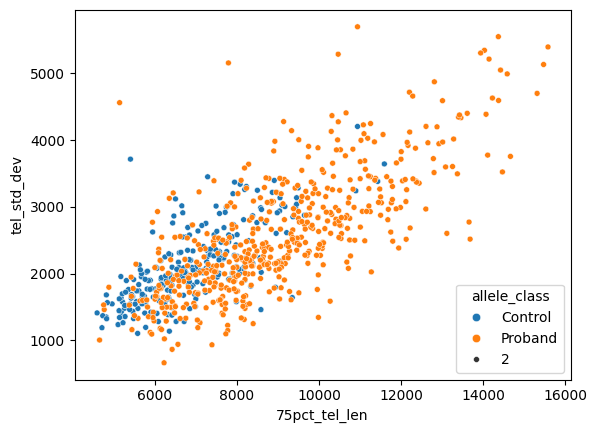

In [58]:
sns.scatterplot(data=std_dev_df,x=f'{operator_for_average}_tel_len',y='tel_std_dev',hue='allele_class',hue_order=['Control','Proband'],
                size=2)

In [61]:
std_dev_df

,allele_id,75pct_tel_len,tel_std_dev,sample,figure_name,allele_class,tel_len_bins,plot_bins
74,825,4601.0,1412.017085,TB-18-04201,Control C,Control,4000-\n5000,True
78,510,4661.0,1005.511986,TB-24-03958,Proband 2,Proband,4000-\n5000,True
84,750,4719.5,1190.332787,TB-15-7719,Control B,Control,4000-\n5000,True
63,729,4739.0,1370.006982,TB-15-7719,Control B,Control,4000-\n5000,True
83,86,4760.5,1531.658331,TB-24-08405,Proband 3(b),Proband,4000-\n5000,True
...,...,...,...,...,...,...,...,...
30,120,14584.0,4993.348596,TB-98-0515,Proband 1(b),Proband,14000-\n15000,True
14,103,14662.0,3757.577464,TB-93-0622,Proband 1(a),Proband,14000-\n15000,True
8,97,15311.5,4701.621569,TB-98-0515,Proband 1(b),Proband,15000-\n16000,False
43,134,15469.5,5134.415460,TB-98-0515,Proband 1(b),Proband,15000-\n16000,False


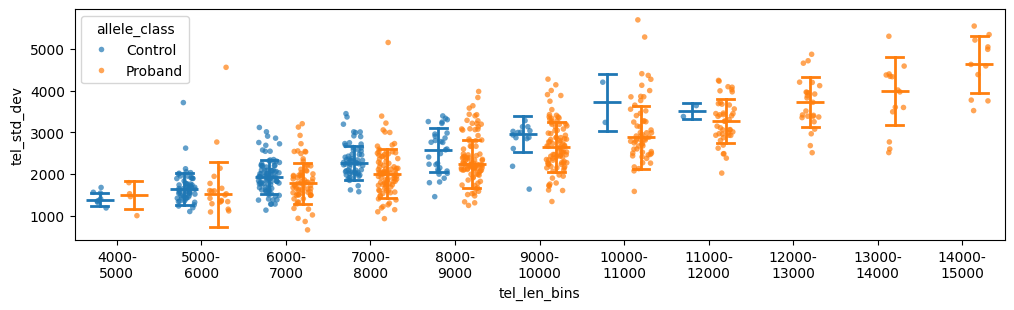

In [62]:
std_dev_df['tel_len_bins'] = std_dev_df[f'{operator_for_average}_tel_len'].apply(lambda x: f'{int(np.floor(x/1000)*1000)}-\n{int(np.ceil(x/1000)*1000)}')
#check to see there are at least 10 datapoints in each bin, otherwise exclude
bins_to_use = [x for x in unique(std_dev_df.tel_len_bins.tolist()) if len(std_dev_df[std_dev_df.tel_len_bins==x])>=10]
std_dev_df['plot_bins'] = std_dev_df.tel_len_bins.apply(lambda x: x in bins_to_use)
std_dev_df.sort_values(by=f'{operator_for_average}_tel_len',inplace=True)

fig,ax = plt.subplots(figsize = (12,3))
i=sns.stripplot(data=std_dev_df[std_dev_df.plot_bins],x='tel_len_bins',y='tel_std_dev', size=4, alpha=0.70,
              hue='allele_class',hue_order=['Control','Proband'],dodge=0.4,jitter=0.25)
j=sns.pointplot(data=std_dev_df[std_dev_df.plot_bins],x='tel_len_bins', y='tel_std_dev',
                hue='allele_class',hue_order=['Control','Proband'],
                errorbar='sd',capsize=.2,linestyle="none",palette=['tab:blue','tab:orange'],linewidth=2,estimator=np.median,
                marker="_", markersize=20, markeredgewidth=2,dodge=0.4,legend=False)



In [43]:
positive_samples = patient_key[patient_key.caPOT1Status=='+']['Sample'].tolist()
negative_samples = patient_key[patient_key.caPOT1Status=='-']['Sample'].tolist()

relevant_cols = ['allele_id']+[x for x in total_aggregated_df.columns if x.split('_')[0] in positive_samples+negative_samples]
pos_neg_df = total_aggregated_df[relevant_cols].copy()

for patient_id in positive_samples+negative_samples:
    pos_neg_df[f'{patient_id}_total_tel_len'] = pos_neg_df.apply(lambda x: get_tel_len_list(x[f'{patient_id}_read_TLs'],True,x[f'{patient_id}_tvr_len']),axis=1)
    pos_neg_df[f'{patient_id}_{operator_for_average}_tel_len'] = pos_neg_df[f'{patient_id}_total_tel_len'].apply(lambda x: find_average(x,operator_for_average))
    pos_neg_df[f'{patient_id}_{operator_for_average}_tel_std_dev'] = pos_neg_df[f'{patient_id}_total_tel_len'].apply(lambda x: np.std(x))

posneg_dict = {'+':'Positive','-':'Negative'}

posneg_std_dev_df = []
for patient_id in positive_samples+negative_samples:
    patient_cols = ['allele_id']+[x for x in pos_neg_df.columns if patient_id in x]
    tdf = pos_neg_df[patient_cols].copy()
    tdf.dropna(subset=f'{patient_id}_tvr_consensus',inplace=True)

    patient_df = pd.DataFrame()
    patient_df['allele_id'] = tdf['allele_id'].tolist()
    patient_df[f'{operator_for_average}_tel_len'] = tdf[f'{patient_id}_{operator_for_average}_tel_len'].tolist()
    patient_df[f'tel_std_dev'] = tdf[f'{patient_id}_{operator_for_average}_tel_std_dev'].tolist()
    patient_df['sample'] = patient_id
    figurename = patient_key[patient_key.Sample==patient_id]['FigureName'].item()
    patient_df['figure_name'] = figurename
    patient_df['allele_class'] = posneg_dict[patient_key[patient_key.Sample==patient_id]['caPOT1Status'].item()]

    posneg_std_dev_df.append(patient_df)
posneg_std_dev_df = pd.concat(posneg_std_dev_df)

<Axes: xlabel='75pct_tel_len', ylabel='tel_std_dev'>

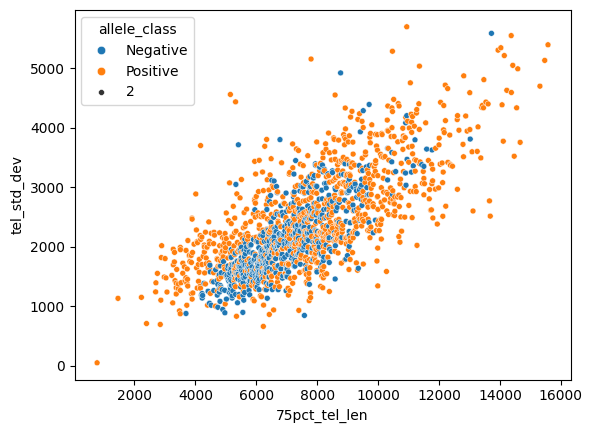

In [57]:
sns.scatterplot(data=posneg_std_dev_df,x=f'{operator_for_average}_tel_len',y='tel_std_dev',hue='allele_class',hue_order=['Negative','Positive'],
                size=2)

(-146.60811037665908, 6000.0)

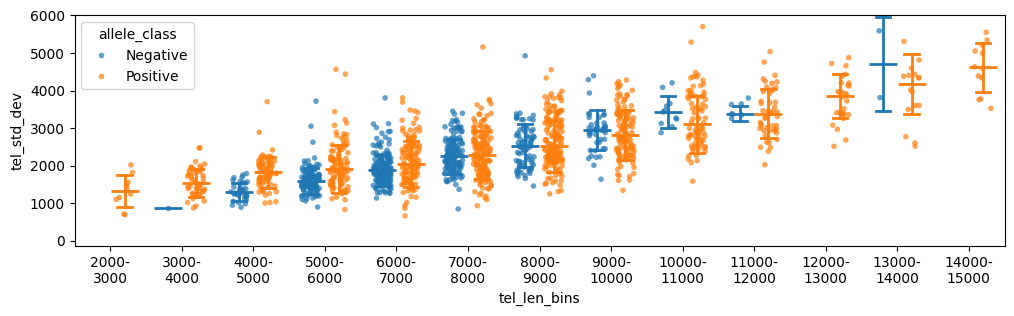

In [56]:
posneg_std_dev_df['tel_len_bins'] = posneg_std_dev_df[f'{operator_for_average}_tel_len'].apply(lambda x: f'{int(np.floor(x/1000)*1000)}-\n{int(np.ceil(x/1000)*1000)}')
#check to see there are at least 10 datapoints in each bin, otherwise exclude
bins_to_use = [x for x in unique(posneg_std_dev_df.tel_len_bins.tolist()) if len(posneg_std_dev_df[posneg_std_dev_df.tel_len_bins==x])>=10]
posneg_std_dev_df['plot_bins'] = posneg_std_dev_df.tel_len_bins.apply(lambda x: x in bins_to_use)
posneg_std_dev_df.sort_values(by=f'{operator_for_average}_tel_len',inplace=True)

fig,ax = plt.subplots(figsize = (12,3))
i=sns.stripplot(data=posneg_std_dev_df[posneg_std_dev_df.plot_bins],x='tel_len_bins',y='tel_std_dev', size=4, alpha=0.70,
              hue='allele_class',hue_order=['Negative','Positive'],dodge=0.4,jitter=0.25)
j=sns.pointplot(data=posneg_std_dev_df[posneg_std_dev_df.plot_bins],x='tel_len_bins', y='tel_std_dev',
                hue='allele_class',hue_order=['Negative','Positive'],
                errorbar='sd',capsize=.2,linestyle="none",palette=['tab:blue','tab:orange'],linewidth=2,estimator=np.median,
                marker="_", markersize=20, markeredgewidth=2,dodge=0.4,legend=False)
ax.set_ylim(min(posneg_std_dev_df.tel_std_dev.tolist())-200,6000)

<Axes: xlabel='75pct_tel_len', ylabel='tel_std_dev'>

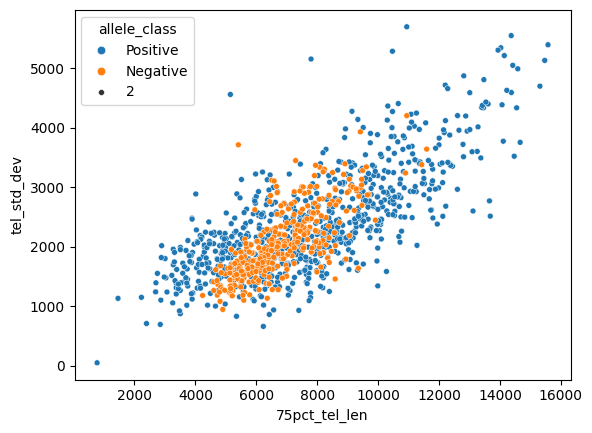

In [52]:
no_nephews_std_dev_df = posneg_std_dev_df[posneg_std_dev_df.figure_name.apply(lambda x: 'Nephew' not in x)]
sns.scatterplot(data=no_nephews_std_dev_df,x=f'{operator_for_average}_tel_len',y='tel_std_dev',hue='allele_class',size=2)